# Building a Spam Filter with Naive Bayes

Addison 2022-09-12

## Introduction

This project aims to employ the multinomial Naive Bayes algorithm to build a spam filter for identifying whether an SMS message is a spam message or not based on a dataset that contains 5,572 SMS messages already classified by humans.

The dataset could be obtained through this link: https://drive.google.com/file/d/1tzm6SQ519P1rCHJPPwYvqvMM2q3lLkoy/view?usp=sharing.


The dataset only has two columns. Since it does not have a header row yet, we will name the columns **Label** and **SMS**:

- **Label:** SMS message category: ham (non-spam) or spam

- **SMS:** the content of the SMS message

In [1]:
import pandas as pd
import numpy as np
import operator


spam = pd.read_csv("/Users/apple/Downloads/python_dataquest/SMSSpamCollection",
                  sep='\t', header = None, names=['Label', 'SMS'])

To start with, let's have a quick look at the first and essential information of the data to imagine what the data looks like as well as get to know the data types of columns and the number of non-null values.

In [2]:
spam.head(10)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [3]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


From the data above, it is evident that the dataset has no missing values and all the data types are object.
Now, we are going to explore the proportion of ham and spam messages in the dataset.

In [4]:
label_percentage = spam["Label"].value_counts(normalize = True)*100
label_percentage

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

## Setting up training and testing sets

Next, we will randomize the whole dataset and split it into training and testing sets. We will also reset the index labels for the two new sets since the index labels become unordered after randomization.

The training set named **training_data** will contain 80% of the rows in the data.

The remaining number of rows in the data will belong to the testing test named **testing_data**.

In [5]:
training_data = spam.sample(frac = 0.8).reset_index(drop = True)
testing_data = spam[~spam.index.isin(training_data.index)].reset_index(drop = True)

## Data cleaning

In this project, we will not take punctuation and capitalization into account and rather focus on pure word and number expression instead.
Thus, we are about to remove all the punctuation from the SMS column. In other words, we will only retain words and numbers in the SMS column. Then, we will transform all the messages into lower case.


In [6]:
training_data["SMS"] = training_data["SMS"].str.replace("\W", " ", regex=True)
training_data["SMS"] = training_data["SMS"].str.lower() 
training_data["SMS"].head()

0                          i m fine  hope you are also
1                      cool  text me when you re ready
2    for ur chance to win  250 cash every wk txt  p...
3    oh  i will get paid  the most outstanding one ...
4    its ok chikku  and its my 1 of favourite song ...
Name: SMS, dtype: object

## Building a vocabulary list

Next, we will start creating a list named **vocabulary** containing unique characters from the SMS column by transforming each message in the SMS column into a list by splitting the string at the space character.

In [7]:
training_data["SMS"] = training_data["SMS"].str.split()
training_data["SMS"].head()

0                   [i, m, fine, hope, you, are, also]
1               [cool, text, me, when, you, re, ready]
2    [for, ur, chance, to, win, 250, cash, every, w...
3    [oh, i, will, get, paid, the, most, outstandin...
4    [its, ok, chikku, and, its, my, 1, of, favouri...
Name: SMS, dtype: object

To build the **vocabulary** list, we will add all the characters from the lists, which have been just created above, to the contemporarily empty list "vocabulary". Then, we will transform the vocabulary list into a set to remove the duplicates from the vocabulary list and transform the vocabulary set back into a list.

In [8]:
vocabulary = []
for sms_list in training_data["SMS"]:
    for word in sms_list:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))
vocabulary[0:10]

['even',
 'blood',
 'ke',
 'club4mobiles',
 'sleepwell',
 'aunty',
 'lingerie',
 'opposed',
 '6days',
 'sindu']

## Data transformation

Next, we are going to create a new data frame called **num_word_per_sms_df** whose column names are unique values in the vocabulary list. Each row of the new data frame represents each message in the training set. For each row, each column will contain the number of occurrences of the column name in the corresponding SMS.

In [9]:
num_word_per_sms = {value: [0]*len(training_data["SMS"]) for value in vocabulary}

for index, sms in enumerate(training_data["SMS"]):
    for word in sms:
        num_word_per_sms[word][index] +=1
        
num_word_per_sms_df = pd.DataFrame(num_word_per_sms)
num_word_per_sms_df.head()


,even,blood,ke,club4mobiles,sleepwell,aunty,lingerie,opposed,6days,sindu,...,dieting,make,constant,prakesh,leaving,performance,entitled,speak,craigslist,standing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we are about to merge the data frame above with the training set to obtain a complete training dataset called **cleaned_training_data**, which is ready for further analysis.

In [10]:
cleaned_training_data = pd.concat([training_data, num_word_per_sms_df], axis =1)
cleaned_training_data.head()

,Label,SMS,even,blood,ke,club4mobiles,sleepwell,aunty,lingerie,opposed,...,dieting,make,constant,prakesh,leaving,performance,entitled,speak,craigslist,standing
0,ham,"[i, m, fine, hope, you, are, also]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[cool, text, me, when, you, re, ready]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,"[for, ur, chance, to, win, 250, cash, every, w...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[oh, i, will, get, paid, the, most, outstandin...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[its, ok, chikku, and, its, my, 1, of, favouri...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Computing elements of the spam filter and establishing parameters

After getting a clean training set, we will start creating a spam filter based on the Naive Bayes algorithm. Specifically, we will use the logic and formulae below to build parameters for the spam filter.

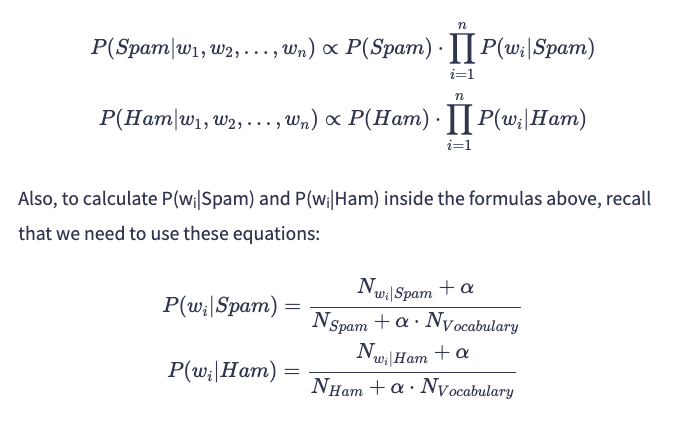

It is also worth noting that all the parameters of the spam filter will be built based on the training set. The testing set will be used later to test our filter.

Firstly, we will identify **P(Spam)** and **P(Ham)**, which are the proportion of spam and ham messages in the dataset respectively.

In this project, **p_spam** and **p_ham** refer to **P(Spam)** and **P(Ham)** respectively.

In [11]:
label_proportion = cleaned_training_data["Label"].value_counts(normalize = True)
label_proportion

ham     0.86227
spam    0.13773
Name: Label, dtype: float64

In [12]:
p_ham = label_proportion[0]
p_ham

0.8622700762673845

In [13]:
p_spam = label_proportion[1]
p_spam

0.13772992373261553

Secondly, we will compute the $N_{Spam}$ and $N_{Ham}$:

- $N_{Spam}$ is the total number of words in all of the SMS messages which are labelled as "spam" (duplicates are counted as well)

- $N_{Ham}$ is the total number of words in all of the SMS messages which are labelled as "ham" (duplicates are counted as well)

In this project, **total_spam_word** and **total_ham_word** refer to $N_{Spam}$ and $N_{Ham}$ respectively.

In [14]:
total_spam_word = 0
total_ham_word = 0

for index, row in cleaned_training_data.iterrows():
    label = row["Label"]
    sms_list = row["SMS"]
    total_word = len(sms_list)
    
    if label == "spam":
            total_spam_word += total_word
    else:
            total_ham_word += total_word
            

total_spam_word         

15660

In [15]:
total_ham_word 

56942

Next, we will split the training set into two sub-datasets **spam_data** and **ham_data** based on the label of the messages. Then, we will calculate the number of occurrences of each word in the vocabulary list in each sub-set:

- $N_{w_{i}|Spam}$: the number of occurrences of a word in the vocabulary list in the spam_data sub-set

- $N_{w_{i}|Ham}$: the number of occurrences of a word in the vocabulary list in the ham_data sub-set

In this project, **word_count_in_spam** and **word_count_in_ham** refer to $N_{w_{i}|Spam}$ and $N_{w_{i}|Ham}$ respectively.

It is also worth noting that $N_{Vocabulary}$ is the number of values in the vocabulary list. We will use the function len() to get $N_{Vocabulary}$ when computing P($w_{i}$|Spam) and P($w_{i}$|Ham).

P($w_{i}$|Spam) and P($w_{i}$|Ham) are the proportion of the number of occurrences of a word in the vocabulary list in the spam_data and ham_data sub-set respectively. In this project, **percentage_word_count_in_spam** and **percentage_word_count_in_ham** refer to P($w_{i}$|Spam) and P($w_{i}$|Ham) respectively.
 
 
In this project, each key-value pair in the two dictionaries **spam_parameter** and **ham_parameter** represents for each word in the vocabulary list as well as its P($w_{i}$|Spam) and P($w_{i}$|Ham) respectively.

It is also worth mentioning that we will use **alpha = 1**, which is commonly known as Laplace smoothing, in this project. Originally, to compute the P($w_{i}$|Spam) or P($w_{i}$|Ham), we just need two elements which are $N_{w_{i}|Spam}$ or $N_{w_{i}|Ham}$ and $N_{Spam}$ or $N_{Ham}$. However, when new words **(those are not in the vocabulary list)** exist in the SMS messages used for testing later, we need to include alpha and $N_{Vocabulary}$ in our formulae to avoid getting probabilities of 0 (specifically, numerator = 0) without distorting the meaning of our results. 

In [16]:
spam_data = cleaned_training_data[cleaned_training_data["Label"] == "spam"]
ham_data = cleaned_training_data[cleaned_training_data["Label"] == "ham"]

alpha = 1

spam_parameter = {}
ham_parameter = {}

for word in vocabulary:
    word_count_in_spam = spam_data[word].sum()
    word_count_in_ham = ham_data[word].sum()
    
    percentage_word_count_in_spam = (word_count_in_spam + alpha)/(total_spam_word + alpha*len(vocabulary))
    percentage_word_count_in_ham = (word_count_in_ham + alpha)/(total_ham_word + alpha*len(vocabulary))

    spam_parameter[word] = percentage_word_count_in_spam
    ham_parameter[word] = percentage_word_count_in_ham

Let's have a look at the top 5 words that have the highest probability of being spam.

In [17]:
dict(sorted(spam_parameter.items(), key=operator.itemgetter(1),reverse=True)[:5])

{'to': 0.024740860811329608,
 'a': 0.012839653627948642,
 'call': 0.012285117092522288,
 'you': 0.009768374354818069,
 'your': 0.00934180778910549}

Let's have a look at the top 5 words that have the highest probability of being ham.

In [18]:
dict(sorted(ham_parameter.items(), key=operator.itemgetter(1),reverse=True)[:5])

{'i': 0.03643105446118192,
 'you': 0.023746620316724604,
 'to': 0.019389725762842796,
 'the': 0.014152182309772113,
 'a': 0.01347238315952105}

Now, we are about to identify the proportion of occurrences of a word **not in** the vocabulary list in the spam_data and ham_data sub-set.

Words which are **not in** the vocabulary list have $N_{w_{i}|Spam}$ = $N_{w_{i}|Ham}$ = 0

In this project, **not_vocab_given_spam_parameter** and **not_vocab_given_ham_parameter** refer to the proportion of the number of occurrence of a word **not in** the vocabulary list in the spam_data and ham_data sub-set respectively.

In [19]:
not_vocab_given_spam_parameter = (0 + alpha)/(total_spam_word + alpha*len(vocabulary))
not_vocab_given_spam_parameter                                  

4.2656656571257946e-05

In [20]:
not_vocab_given_ham_parameter = (0 + alpha)/(total_ham_word + alpha*len(vocabulary))
not_vocab_given_ham_parameter

1.544998068752414e-05

## Building spam filters

### The spam filter for single messages

Next, we are going to build a function called **spam_detector_for_single_message**, which takes in a message (a string) and prints P(Spam|message) and P(Ham|message) of that message.

- If P(Spam|message) > P(Ham|message), the function further prints "This is a spam message"

- If P(Spam|message) < P(Ham|message), the function further prints "This is a ham message"

- If P(Spam|message) = P(Ham|message), the function further prints "Equal probabilities. The message needs to be classified by human!"


Regarding the logic of the function, it firstly removes all the punctuation from the inputted message and transforms all the characters into lower case. Then, it classifies each word in the message into two lists **word_in_vocab** and **word_not_in_vocab**.

- **word_in_vocab** contains words in the message which also exist in the vocabulary list

- **word_not_in_vocab** contains words in the message which do not exist in the vocabulary list


Next, each word in the **word_in_vocab** list will take corresponding values in the **spam_parameter** and **ham_parameter** dictionaries, which will be placed in the **vocab_spam_percentage** and **vocab_ham_percentage** respectively afterwards.

In the meanwhile, each word in the **word_not_in_vocab** list will take corresponding values from variables **not_vocab_given_spam_parameter** and **not_vocab_given_ham_parameter**, which will be placed in the **not_vocab_spam_percentage** and **not_vocab_ham_percentage** respectively afterwards.

Next, P(Spam|message) will be computed by multiplying all the values in the **vocab_spam_percentage** and **not_vocab_spam_percentage** list as well as the **p_spam**. 

On the other hand, P(Ham|message) will be computed by multiplying all the values in the **vocab_ham_percentage** and **not_vocab_ham_percentage** list as well as the **p_ham**. 

Afterwards, the function will compare the values of P(Spam|message) and P(Ham|message) and then print corresponding outputs which are mentioned previously.


For clarification, here are the formulae for calculating P(Spam|message) and P(Ham|message):


- P(Spam|$w_{1}, w_{2},.., w_{n}$) = P(Spam) * P($w_{1}$|Spam) * P($w_{2}$|Spam) * ... * P($w_{n}$|Spam)

- P(Ham|$w_{1}, w_{2},.., w_{n}$) = P(Ham) * P($w_{1}$|Ham) * P($w_{2}$|Ham) * ... * P($w_{n}$|Ham)





In [21]:
import re

def spam_detector_for_single_message(message):
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    word_in_vocab = []
    vocab_spam_percentage = []
    vocab_ham_percentage = []
    
    word_not_in_vocab = []
    not_vocab_spam_percentage = []
    not_vocab_ham_percentage = []

    
    for word in message:
        if word in vocabulary:
            word_in_vocab.append(word)
        else:
            word_not_in_vocab.append(word)
    
    for word in word_in_vocab:
        vocab_spam_percentage.append(spam_parameter[word])
        vocab_ham_percentage.append(ham_parameter[word])
    
    for word in word_not_in_vocab:
        not_vocab_spam_percentage.append(not_vocab_given_spam_parameter)
        not_vocab_ham_percentage.append(not_vocab_given_ham_parameter)
    
    p_spam_given_message = p_spam*np.product(vocab_spam_percentage)*np.product(not_vocab_spam_percentage)
    p_ham_given_message = p_ham*np.product(vocab_ham_percentage)*np.product(not_vocab_ham_percentage)
    
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('This is a ham message')
    elif p_ham_given_message < p_spam_given_message:
        print('This is a spam message')
    else:
        print('Equal probabilities. The message needs to be classified by humans!')

Now, we are going to test the function above with a random message to see what the output looks like.

In [22]:
spam_detector_for_single_message("Hire me or regret later!")

P(Spam|message): 6.454145487419106e-20
P(Ham|message): 7.331871177004851e-17
This is a ham message


### The spam filter for datasets

Next, we will create another function called **spam_detector_for_dataset**, which is appropriate for testing a dataset rather than a single message. To this end, we will modify the **spam_detector_for_single_message** by replacing all the function print() with return().

In [23]:
def spam_detector_for_dataset(message):
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    word_in_vocab = []
    vocab_spam_percentage = []
    vocab_ham_percentage = []
    
    word_not_in_vocab = []
    not_vocab_spam_percentage = []
    not_vocab_ham_percentage = []

    
    for word in message:
        if word in vocabulary:
            word_in_vocab.append(word)
        else:
            word_not_in_vocab.append(word)
    
    for word in word_in_vocab:
        vocab_spam_percentage.append(spam_parameter[word])
        vocab_ham_percentage.append(ham_parameter[word])
    
    for word in word_not_in_vocab:
        not_vocab_spam_percentage.append(not_vocab_given_spam_parameter)
        not_vocab_ham_percentage.append(not_vocab_given_ham_parameter)
    
    p_spam_given_message = p_spam*np.product(vocab_spam_percentage)*np.product(not_vocab_spam_percentage)
    p_ham_given_message = p_ham*np.product(vocab_ham_percentage)*np.product(not_vocab_ham_percentage)
    
    if p_ham_given_message > p_spam_given_message:
        return "ham"
    elif p_ham_given_message < p_spam_given_message:
        return "spam"
    else:
        return ('Equal proabilities. The message needs to be classified by humans!')

Now, we are about to use the testing set to test the function above. All the outputs from the function will be placed in a new column named **"Detection"**.

In [24]:
testing_data["Detection"] = testing_data["SMS"].apply(spam_detector_for_dataset)
testing_data.head(10)

,Label,SMS,Detection
0,ham,Aight should I just plan to come up later toni...,ham
1,ham,Die... I accidentally deleted e msg i suppose ...,ham
2,spam,Welcome to UK-mobile-date this msg is FREE giv...,spam
3,ham,This is wishing you a great day. Moji told me ...,ham
4,ham,Thanks again for your reply today. When is ur ...,ham
5,ham,"Sorry I flaked last night, shit's seriously go...",ham
6,ham,He said i look pretty wif long hair wat. But i...,ham
7,ham,Ranjith cal drpd Deeraj and deepak 5min hold,ham
8,ham,CHEERS FOR CALLIN BABE.SOZI CULDNT TALKBUT I W...,ham
9,ham,Hey u still at the gym?,ham


## Model evaluation

Finally, we will measure the accuracy of the spam filter by having the number of correctly classified messages by the
total number of classified messages.

In [25]:
num_correct_label = 0

for index, row in testing_data.iterrows():
    label = row["Label"]
    detection = row["Detection"]
    
    if label == detection:
        num_correct_label += 1
        
accuracy = num_correct_label/len(testing_data)
accuracy

0.9883303411131059

The accuracy rate of the spam filter is pretty high, indicating that the spam filter produces considerably reliable results. However, it is still suggested that further research could take other issues such as punctuation and capitalization into account when building a spam filter to see whether they help improve the accuracy of the filter.